In [1]:
# # Run this and then restart the kernel at the start of each session to install
# # 'teotil3' in development mode
# !pip install -e /home/jovyan/projects/teotil3/

In [2]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import utils

plt.style.use("ggplot")

# TEOTIL3 Trondheimsfjorden

# Part 5: Generate model input files for agricultural scenarios

NIBIO have provided updated Excel templates containing scenarios data for TEOTIL3 around Trondheimsfjorden. The default/baseline scenario has also been adjusted slightly. This notebook reads the "standard" input files generated for TEOTIL3, filters them to only consider Trondheimsfjorden, and then replaces the default agricultural data with data read from the new NIBIO templates. The output is a set of model input files for each scenario.

## 1. User input

In [3]:
agri_loss_model = "annual"
nve_data_year = 2024
st_yr, end_yr = 2013, 2023
orig_data_fold = f"/home/jovyan/shared/common/teotil3/annual_input_data"
scen_data_fold = (
    r"/home/jovyan/shared/common/teotil3/trondheimsfjorden_scenarios/agri_raw"
)
scen_version = "20241121"
scen_out_fold = r"/home/jovyan/shared/common/teotil3/trondheimsfjorden_scenarios/teotil3_input_files"

# Vassdragsområder draining to Trondheimsfjorden
vassoms = range(120, 133)

# Scenarios from NIBIO
scen_list = [
    "Baseline",
    "SC1",
    "SC2",
    "SC4",
    "SC5",
    "SC6",
    "SC7a",
    "SC7b",
    "SC8",
    "SC9",
]

scen_data_fold = os.path.join(scen_data_fold, f"agri_data_v{scen_version}")

## 2. Compare old and new baselines

For agricultural N, Franziska has made some changes to the `Baseline` scenario for Trondheimsfjorden. We may eventually apply these changes nationally, but for now I want to compare the new baseline with the original. Note that values for other parameters (P, SS and TOC) should be the same as before.

**Update 22.11.2024:** NIBIO has generated a new national baseline dataset (see e-mail from Sigrun received 22.11.2024). The Trondheimsfjorden baseline should now be identical to the national baseline, so points on the plots below should all lie along the 1:1 line.

In [4]:
df_list = []
for year in range(st_yr, end_yr + 1):
    # Read 'default' TEOTIL3 input file
    orig_csv = os.path.join(
        orig_data_fold,
        f"agri_{agri_loss_model}_loss",
        f"teotil3_input_data_nve{nve_data_year}_{year}.csv",
    )
    orig_df = pd.read_csv(orig_csv)

    # Filter to Trondheimsfjorden
    orig_df["vassom"] = (
        orig_df["regine"].str.split(".", n=1, expand=True)[0].astype(int)
    )
    orig_df = orig_df.query("vassom in @vassoms").reset_index(drop=True)
    del orig_df["vassom"]

    # Read the new baseline scenario
    base_df = utils.read_raw_agri_scen_data(year, "Baseline", scen_data_fold)

    # Join agri columns
    orig_df = orig_df[base_df.columns]
    comp_df = pd.merge(
        orig_df, base_df, how="left", on="regine", suffixes=("_old", "_new")
    )
    comp_df["year"] = year
    comp_df = comp_df.fillna(0).round(0)
    df_list.append(comp_df)
comp_df = pd.concat(df_list, axis="rows")

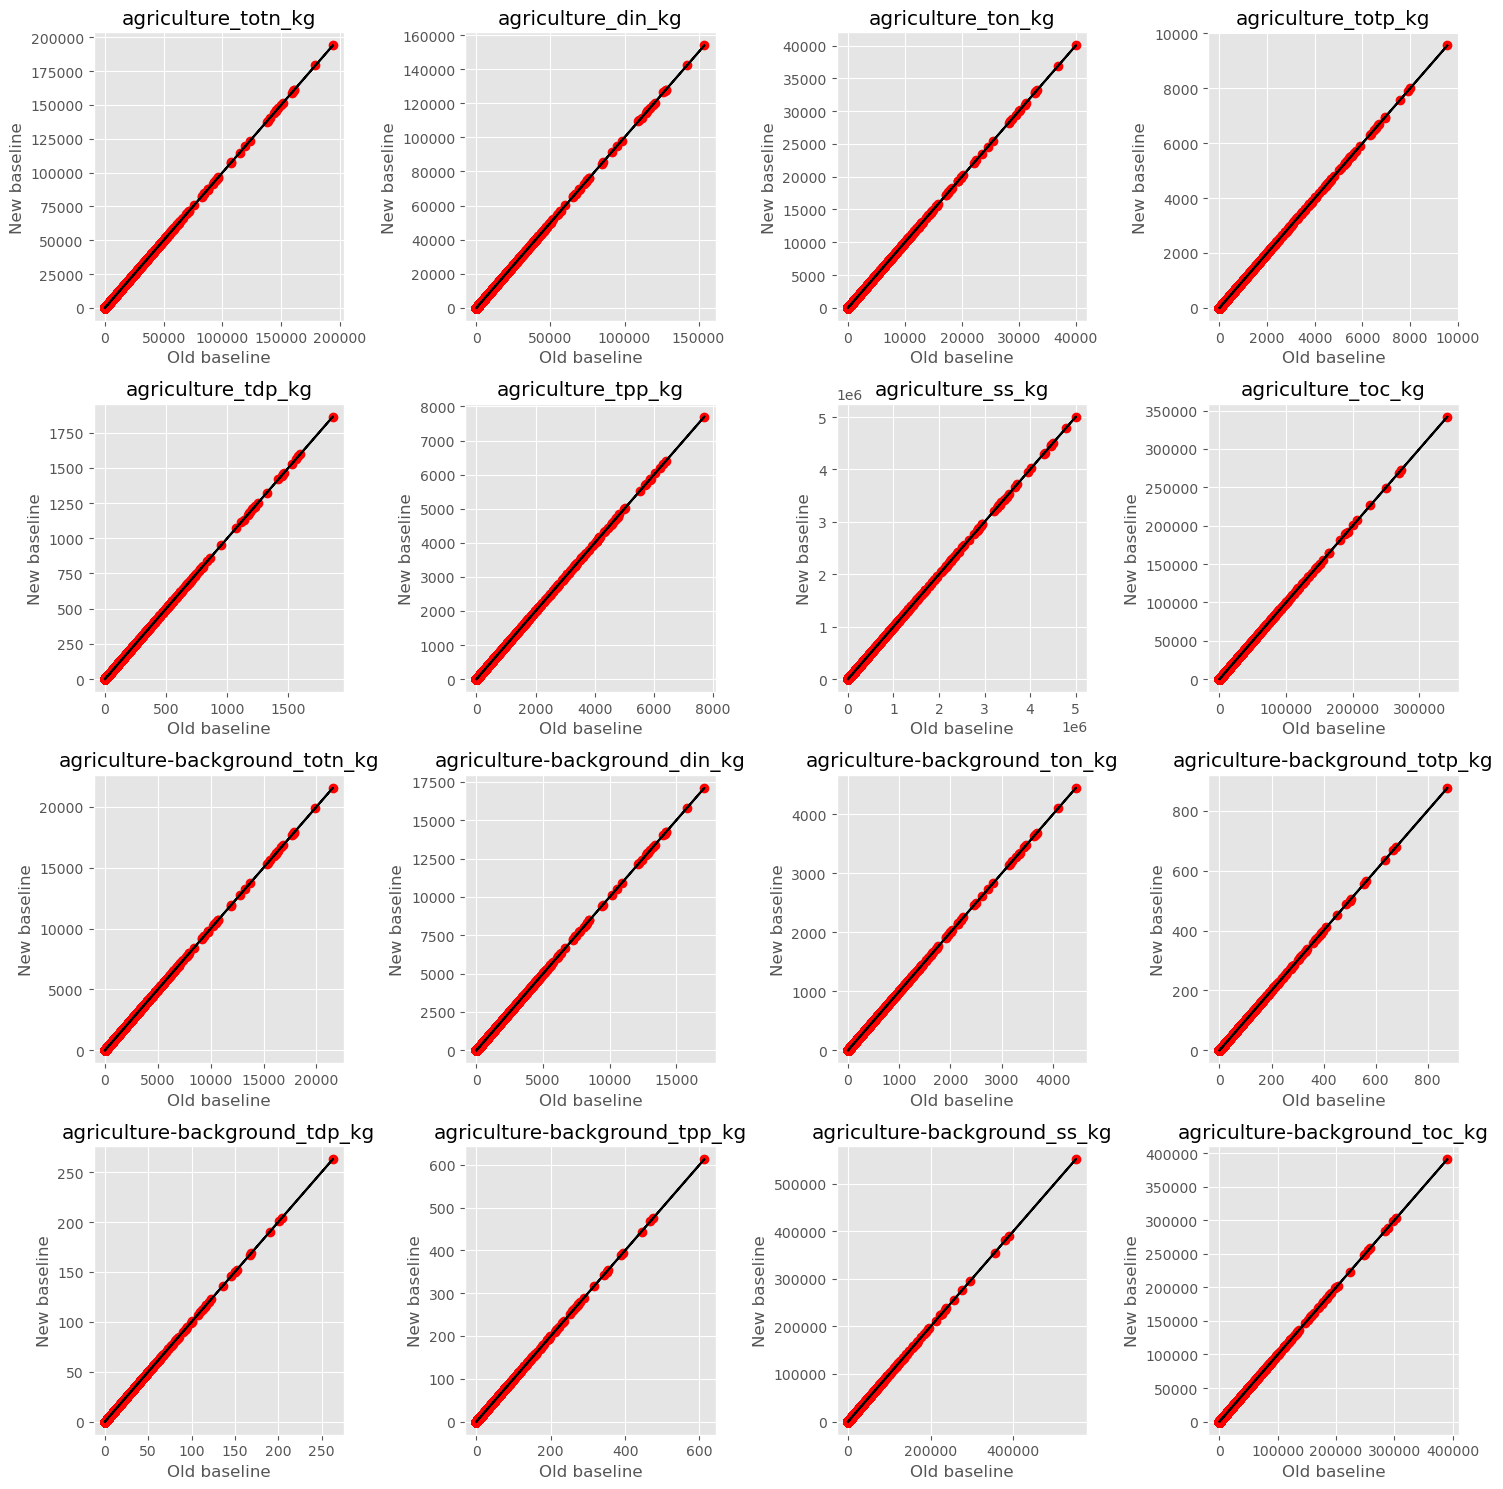

In [5]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 15))
axes = axes.flatten()
for idx, col in enumerate(base_df.drop(columns="regine").columns):
    axes[idx].plot(comp_df[f"{col}_old"], comp_df[f"{col}_new"], "ro")
    axes[idx].plot(comp_df[f"{col}_old"], comp_df[f"{col}_old"], "k-")
    axes[idx].set_title(col)
    axes[idx].set_xlabel("Old baseline")
    axes[idx].set_ylabel("New baseline")
plt.tight_layout()

## 3. Generate new input files

In [6]:
for year in range(st_yr, end_yr + 1):
    # Read 'default' TEOTIL3 input file
    orig_csv = os.path.join(
        orig_data_fold,
        f"agri_{agri_loss_model}_loss",
        f"teotil3_input_data_nve{nve_data_year}_{year}.csv",
    )
    orig_df = pd.read_csv(orig_csv)

    # Filter to Trondheimsfjorden
    orig_df["vassom"] = (
        orig_df["regine"].str.split(".", n=1, expand=True)[0].astype(int)
    )
    orig_df = orig_df.query("vassom in @vassoms").reset_index(drop=True)
    del orig_df["vassom"]

    # Read the new baseline scenario
    base_df = utils.read_raw_agri_scen_data(year, "Baseline", scen_data_fold)

    # Process scenarios
    for scen in scen_list:
        if scen == "Baseline":
            scen_df = base_df.copy()
        else:
            scen_df = utils.read_raw_agri_scen_data(year, scen, scen_data_fold)

            # Blank columns in the scenarios template should be the same as the baseline
            for col in scen_df.columns:
                if scen_df[col].isna().all():
                    del scen_df[col]
                    scen_df = pd.merge(
                        scen_df, base_df[["regine", col]], how="left", on="regine"
                    )

        # Update inputs with scenario data
        agri_cols = [col for col in scen_df.drop(columns="regine").columns]
        non_agri_df = orig_df.drop(columns=agri_cols).copy()
        scen_df = pd.merge(non_agri_df, scen_df, how="left", on="regine")
        scen_df.fillna({col: 0 for col in agri_cols}, inplace=True)

        # Save
        scen_dir = os.path.join(scen_out_fold, scen)
        scen_csv = os.path.join(
            scen_dir,
            f"trondheimsfjorden_input_data_scen-{scen.lower()}_nve{nve_data_year}_{year}.csv",
        )
        if not os.path.exists(scen_dir):
            os.makedirs(scen_dir)
        scen_df.to_csv(scen_csv, index=False)

## 4. Compare scenarios

In [7]:
df_list = []
for scen in scen_list:
    for year in range(st_yr, end_yr + 1):
        scen_dir = os.path.join(scen_out_fold, scen)
        scen_csv = os.path.join(
            scen_dir,
            f"trondheimsfjorden_input_data_scen-{scen.lower()}_nve{nve_data_year}_{year}.csv",
        )
        scen_df = pd.read_csv(scen_csv)
        scen_df["scenario"] = scen.lower()
        scen_df["year"] = year
        df_list.append(scen_df)
df = pd.concat(df_list, axis="rows")

input_cols = [col for col in df.columns if col.endswith("_kg")]
id_cols = ["regine", "scenario", "year"]
df = df[id_cols + input_cols].melt(id_vars=id_cols).reset_index(drop=True)
df[["source", "par_unit"]] = df["variable"].str.split("_", n=1, expand=True)
del df["variable"]

# Filter to just agriculture and sum over all years
src_list = ["agriculture", "agriculture-background"]
df = (
    df.query("source in @src_list")
    .groupby(["scenario", "source", "par_unit"])
    .sum(numeric_only=True)
    .reset_index()
)
del df["year"]

# Converts to tonnes and mean value per year (instead of summing over all years)
df["value"] = df["value"] / (len(range(st_yr, end_yr + 1)) * 1000)
df["par_unit"] = df["par_unit"].str.replace("_kg", "_tonnespyr")

df.head()

,scenario,source,par_unit,value
0,baseline,agriculture,din_tonnespyr,3582.633130
1,baseline,agriculture,ss_tonnespyr,93682.889261
2,baseline,agriculture,tdp_tonnespyr,42.022950
3,baseline,agriculture,toc_tonnespyr,6370.477415
4,baseline,agriculture,ton_tonnespyr,968.377384


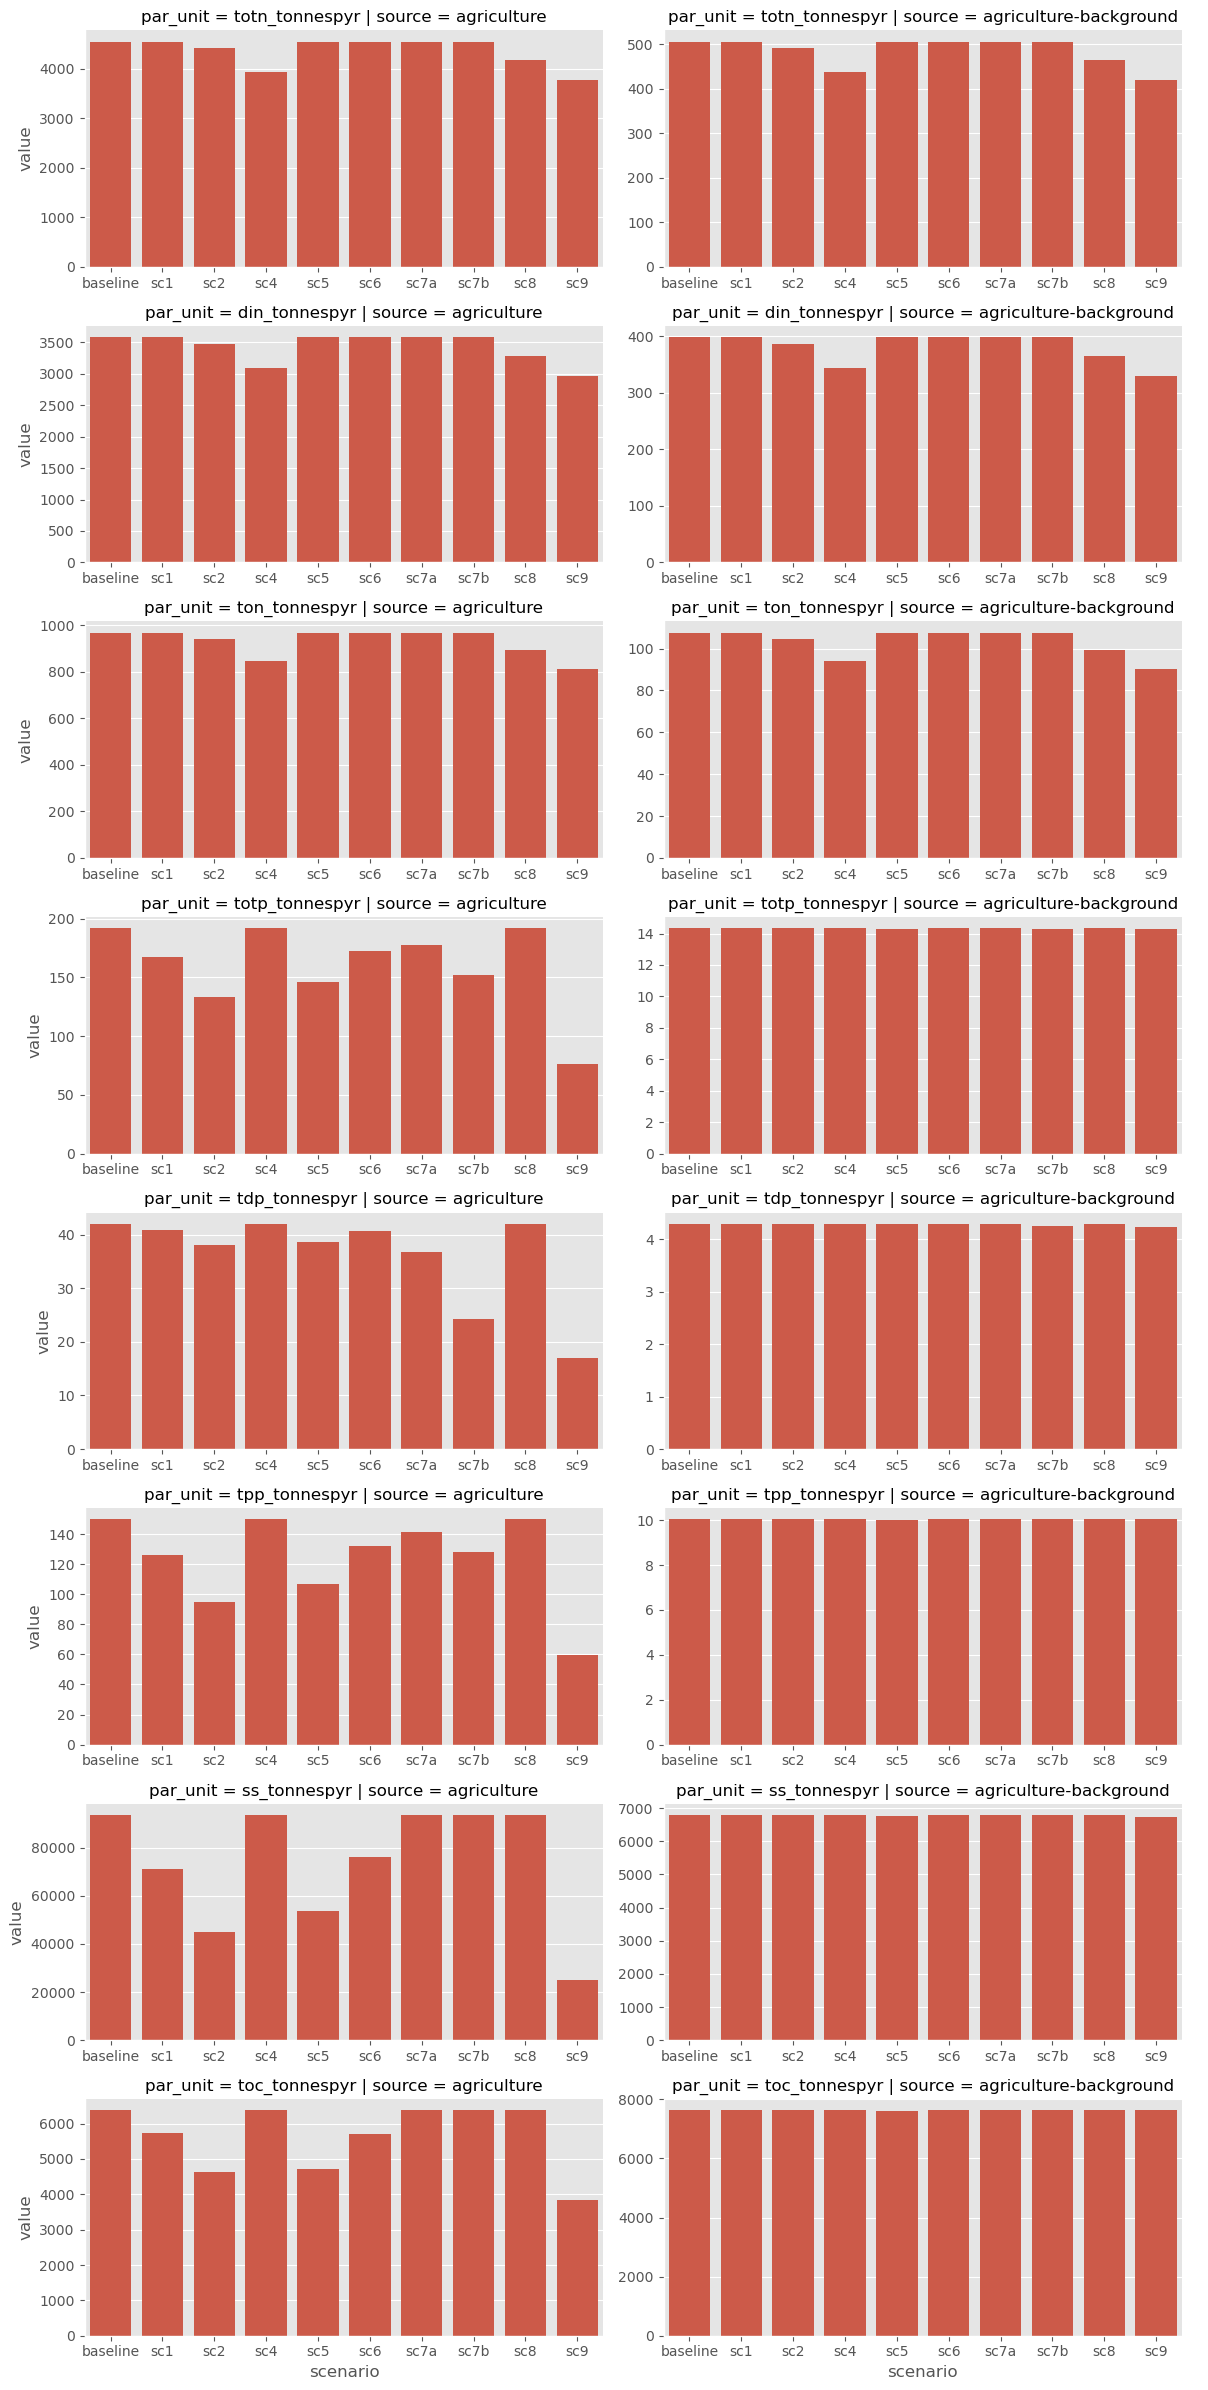

In [8]:
pars = ["totn", "din", "ton", "totp", "tdp", "tpp", "ss", "toc"]
row_order = [f"{par}_tonnespyr" for par in pars]
sn.catplot(
    data=df,
    x="scenario",
    y="value",
    row="par_unit",
    col="source",
    kind="bar",
    row_order=row_order,
    sharex=False,
    sharey=False,
    height=3,
    aspect=2,
)
png_path = r"../results/images/scenario_changes_tonnespyr.png"
plt.savefig(png_path, dpi=200, bbox_inches="tight")